I'm looking into doing a delta_sigma emulator. This is testing if the cat side works. Then i'll make an emulator for it. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [4]:
zbc = (z_bins[1:]+z_bins[:-1])/2
print 1/(1+zbc)

[ 0.81632653  0.72727273  0.6557377   0.59701493  0.54794521]


In [5]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [6]:
print z

0.232741617357


In [7]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a, particles=True, tol = 0.01, downsample_factor=1e-3)

In [8]:
cat.load_model(a, 'redMagic')

In [9]:
from astropy import cosmology

In [10]:
params = cat.model.param_dict.copy()
#params['mean_occupation_centrals_assembias_param1'] = 0.0
#params['mean_occupation_satellites_assembias_param1'] = 0.0
#my clustering redmagic best fit
params['logMmin'] = 12.386
params['sigma_logM'] = 0.4111
params['f_c'] = 0.292
params['alpha'] = 1.110
params['logM1'] = 13.777
params['logM0'] = 11.43433

print params

{'logM1': 13.777, 'logMmin': 12.386, 'f_c': 0.292, 'logM0': 11.43433, 'sigma_logM': 0.4111, 'alpha': 1.11}


In [11]:
print cat

chinchilla
-------------------------
Halo finder:	 rockstar
Version name:	Lb400-2048
Cosmology:
LambdaCDM(H0=70 km / (Mpc s), Om0=0.286, Ode0=0.714, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=None)
Redshifts:	[0.23274161735700183]
-------------------------
Location:	/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/c400-2048//rockstar/hlists/
Lbox:	400.0
Particle Mass:	591421440.000000
Columns to Keep:
{'halo_upid': (6, 'i8'), 'halo_vacc': (56, 'f4'), 'halo_vmax': (16, 'f4'), 'halo_rs_klypin': (34, 'f4'), 'halo_snapnum': (31, 'i8'), 'halo_macc': (54, 'f4'), 'halo_halfmass_scale': (58, 'f4'), 'halo_y': (18, 'f4'), 'halo_id': (1, 'i8'), 'halo_x': (17, 'f4'), 'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'), 'halo_rs': (12, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_vpeak': (57, 'f4'), 'halo_z': (19, 'f4'), 'halo_mvir': (10, 'f4')}


In [12]:
help(cat.calc_gt)

Help on method calc_gt in module pearce.mocks.cat:

calc_gt(self, *args, **kwargs) method of pearce.mocks.kittens.Chinchilla instance
    Calculate the tangential shear gamma tvia delta sigma
    :param theta_bins:
        Angular bins (in radians) to compute gamma t
    :param sigma_crit_inv:
        The inverse of sigma_crit for the lensing sample
    :param use_halotools:
        How to compute delta_sigma. If we use halotools, small scales will be more accuate, but larger
        scales will be more accurate with the analytic techinques (scales comparable to the boxsize). 
        Default is True.
    :param n_cores:
        Number of cores to use in the calculation. Default is 'all'
    :param ds_kwargs:
        Any kwargs to pass into delta_sigma. Default is {}.
    :return:
        Gamma t



In [13]:
cat.populate(params)

In [14]:
nd_cat =  cat.calc_analytic_nd(params)
print nd_cat

0.000288586509328


In [15]:
fname = '/u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits'
hdulist = fits.open(fname)

In [16]:
nz_sources = hdulist[6]
sources_zbin = 1
N_z = np.array([row[2+sources_zbin] for row in nz_sources.data])
N_total =  np.sum(N_z)#*0.01
N_z/=N_total # normalize

zbins = [row[0] for row in nz_sources.data]
zbins.append(nz_sources.data[-1][2])

In [17]:
sc_inv = cat.calc_sigma_crit_inv(zbins, N_z)
print sc_inv

0.000123904180342


In [18]:
zs = np.sum(zbins[:-1]*N_z)

In [19]:
zs

0.34258590153130453

In [20]:
sc_inv

0.0001239041803415539

In [21]:
rp_bins = np.logspace(-1.1, 1.8, 20) #binning used in buzzard mocks
#rpoints = (rp_bins[1:]+rp_bins[:-1])/2

theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60
#theta_bins = cat._ang_from_rp(rp_bins)
#rp_bins = cat._rp_from_ang(theta_bins)
rpoints = np.sqrt(rp_bins[1:]*rp_bins[:-1])
tpoints = np.sqrt(theta_bins[1:]*theta_bins[:-1])#(theta_bins[1:]+theta_bins[:-1])/2

In [22]:
gt = cat.calc_gt(theta_bins, 1.0, n_cores = 2)

[  0.55742891   0.70176142   0.88346528   1.11221689   1.40019811
   1.76274498   2.21916445   2.79376251   3.51713862   4.42781519
   5.57428906   7.01761415   8.83465278  11.12216889  14.00198106
  17.62744977  22.19164446  27.93762513  35.17138623  44.27815189
  55.7428906 ]


In [23]:
from scipy.interpolate import interp1d
from scipy.integrate import quad
import pyccl as ccl

[]

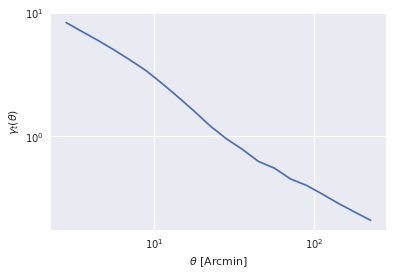

In [24]:
tbins = (theta_bins[1:]+theta_bins[:-1])/2.0

plt.plot(tbins*60, gt)
plt.ylabel(r'$\gamma_t(\theta)$')
plt.xlabel(r'$\theta$ [Arcmin]')
plt.loglog()

In [25]:
gt_data = hdulist[3].data
gt_rm, gt_bc = [],[]
for i, row in enumerate(gt_data):
    if i == 20:
        break
    gt_rm.append(row[3])#gt_data[3,:20]
    gt_bc.append(row[4])


In [26]:
print gt_bc
print tbins*60

[2.8284525760820651, 3.5611100626979235, 4.4832324135353927, 5.6444263949858096, 7.106467297987006, 8.9470680509631713, 11.263751950185547, 14.180543270537312, 17.852323155753165, 22.475065080603613, 28.294328659304032, 35.620811384702627, 44.843320233386507, 56.454311248355957, 71.070399228697539, 89.469220057323227, 112.63138689765957, 141.78536304480295, 178.4862435722506, 224.67293751732211]
[   2.82365676    3.55477326    4.47519438    5.63393593    7.09270511
    8.92918671   11.24118005   14.15180723   17.81606974   22.42910293
   28.23656765   35.54773255   44.75194384   56.33935933   70.92705115
   89.29186707  112.41180052  141.51807226  178.1606974   224.29102934]


In [27]:
gt_rm, gt

([0.00057909443283527277,
  0.00075844018290375007,
  0.00051850962632699364,
  0.00053758798484659562,
  0.00035584157482638064,
  0.00038287288254570929,
  0.00033117365509588773,
  0.00018444683702616453,
  0.00019728601131120023,
  0.00017259687669257228,
  0.00010352570241177796,
  9.7916032948876309e-05,
  8.1023657293956486e-05,
  7.8309766692132387e-05,
  7.4532526832869536e-05,
  6.0607272858477835e-05,
  4.3082342739862917e-05,
  4.2046111399494965e-05,
  3.4032897800263938e-05,
  2.9131614374755984e-05],
 array([ 8.29765841,  7.0136253 ,  5.94207669,  4.98119378,  4.12790198,
         3.38714666,  2.6648658 ,  2.07209764,  1.59309205,  1.21029242,
         0.95653408,  0.78541169,  0.6283067 ,  0.55372474,  0.45387422,
         0.40221351,  0.34139928,  0.28728537,  0.24524206,  0.21019669]))

[]

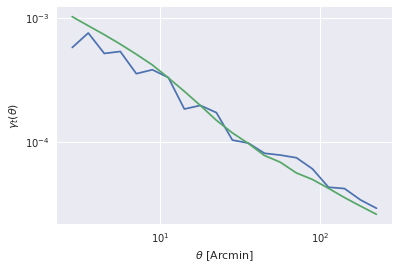

In [29]:
plt.plot(gt_bc, gt_rm)
plt.plot(tbins*60, sc_inv*gt)#/cat.h)
plt.ylabel(r'$\gamma_t(\theta)$')
plt.xlabel(r'$\theta$ [Arcmin]')
plt.loglog()